In [8]:
import os
import pandas as pd
import librosa
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Download the dataset
!wget -q https://github.com/karolpiczak/ESC-50/archive/master.zip
!unzip -q master.zip

# Load the metadata
metadata = pd.read_csv('ESC-50-master/meta/esc50.csv')

# Filter to include only animal sounds
animal_sounds = metadata[metadata['category'].isin(['dog', 'cat', 'bird', 'cow', 'frog'])]

# Function to load audio files and extract features
def load_audio(file_path):
    y, sr = librosa.load(file_path, sr=None)
    return y, sr

def extract_features(y, sr):
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
    log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
    return log_spectrogram

# Extract features and prepare dataset
X = []
y = []
for idx, row in animal_sounds.iterrows():
    file_path = f"ESC-50-master/audio/{row['filename']}"
    y_audio, sr = load_audio(file_path)
    features = extract_features(y_audio, sr)
    X.append(features)
    y.append(row['category'])

X = np.array(X)
y = np.array(y)

# Encode labels
label_map = {label: idx for idx, label in enumerate(np.unique(y))}
y = np.array([label_map[label] for label in y])

# Expand dimensions for CNN
X = np.expand_dims(X, axis=-1)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# One-hot encode labels
y_train = to_categorical(y_train, num_classes=len(label_map))
y_test = to_categorical(y_test, num_classes=len(label_map))


replace ESC-50-master/.circleci/config.yml? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace ESC-50-master/.github/stale.yml? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
y


In [9]:
# Define the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(label_map), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/30
4/4 [==============================] - 10s 2s/step - loss: 1074.0260 - accuracy: 0.1641 - val_loss: 111.0377 - val_accuracy: 0.1875
Epoch 2/30
4/4 [==============================] - 8s 2s/step - loss: 374.1755 - accuracy: 0.2891 - val_loss: 34.4438 - val_accuracy: 0.1250
Epoch 3/30
4/4 [==============================] - 9s 2s/step - loss: 81.1257 - accuracy: 0.3125 - val_loss: 6.9450 - val_accuracy: 0.2812
Epoch 4/30
4/4 [==============================] - 13s 4s/step - loss: 23.9437 - accuracy: 0.3047 - val_loss: 1.4155 - val_accuracy: 0.2812
Epoch 5/30
4/4 [==============================] - 8s 2s/step - loss: 5.6378 - accuracy: 0.3047 - val_loss: 1.3524 - val_accuracy: 0.5938
Epoch 6/30
4/4 [==============================] - 8s 2s/step - loss: 1.2100 - accuracy: 0.4609 - val_loss: 1.2001 - val_accuracy: 0.5938
Epoch 7/30
4/4 [==============================] - 9s 2s/step - loss: 0.9706 - accuracy: 0.5938 - val_loss: 1.1588 - val_accuracy: 0.6562
Epoch 8/30
4/4 [=============

In [11]:
model.save('trained_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [13]:
from google.colab import files
files.download('trained_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#transfer learning

In [20]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)
datagen.fit(X_train)

# Define the model
model2 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(label_map), activation='softmax')
])

# Compile the model
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model2.fit(datagen.flow(X_train, y_train, batch_size=32),
                    epochs=50,
                    validation_data=(X_test, y_test),
                    callbacks=[reduce_lr, early_stopping])


Epoch 1/50
4/4 [==============================] - 27s 6s/step - loss: 133.4811 - accuracy: 0.2812 - val_loss: 2.8852 - val_accuracy: 0.1250 - lr: 0.0010
Epoch 2/50
4/4 [==============================] - 25s 6s/step - loss: 7.6253 - accuracy: 0.2969 - val_loss: 1.4342 - val_accuracy: 0.3438 - lr: 0.0010
Epoch 3/50
4/4 [==============================] - 24s 6s/step - loss: 1.6656 - accuracy: 0.2344 - val_loss: 1.3873 - val_accuracy: 0.1875 - lr: 0.0010
Epoch 4/50
4/4 [==============================] - 24s 6s/step - loss: 1.3856 - accuracy: 0.2578 - val_loss: 1.3868 - val_accuracy: 0.3125 - lr: 0.0010
Epoch 5/50
4/4 [==============================] - 25s 6s/step - loss: 1.3750 - accuracy: 0.2656 - val_loss: 1.3868 - val_accuracy: 0.3125 - lr: 0.0010
Epoch 6/50
4/4 [==============================] - 24s 6s/step - loss: 1.3930 - accuracy: 0.2500 - val_loss: 1.3870 - val_accuracy: 0.2812 - lr: 0.0010
Epoch 7/50
4/4 [==============================] - 25s 6s/step - loss: 1.3835 - accuracy: 0.2

1/1 - 0s - loss: 1.4412 - accuracy: 0.8438 - 497ms/epoch - 497ms/step
Test accuracy: 0.8438


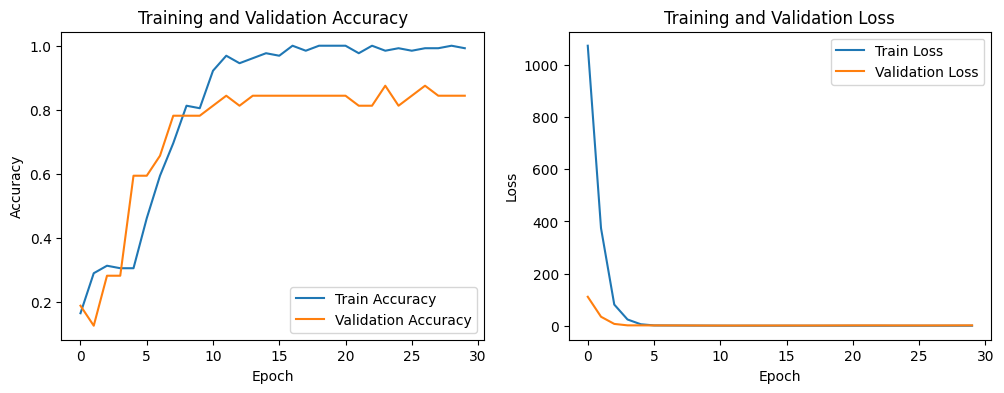

In [10]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f'Test accuracy: {test_acc:.4f}')

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [24]:
from tensorflow.keras.models import load_model
# Load the model
loaded_model = load_model('trained_model.h5')

# Evaluate the loaded model
loss, accuracy = loaded_model.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')


1/1 [==============================] - 1s 583ms/step - loss: 1.4412 - accuracy: 0.8438
Loss: 1.4411646127700806, Accuracy: 0.84375


In [25]:
!pip install sounddevice


y
